# Poor Mans Luno

Author: Marcel Coetzee

In [1]:
%matplotlib inline
import io
import time
from datetime import date, datetime

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
def get_historical_usd_zar(start_date_obj, end_date_obj):
    """
    Retrieves historical USD/ZAR prices
    """

    url_usd_zar = (
        f"https://query1.finance.yahoo.com/v7/finance/download/ZAR=X?period1="
        f"{start_date_obj.timestamp():.0f}&period2={end_date_obj.timestamp():.0f}&"
        f"interval=1d&events=history&includeAdjustedClose=true"
    )

    rates_resp = requests.get(url_usd_zar)

    with io.StringIO(str(rates_resp.content, "utf-8")) as data_stream:
        close_prices = pd.read_csv(data_stream)

    close_prices["Date"] = pd.to_datetime(close_prices["Date"])
    close_prices = close_prices.set_index("Date")["Close"]

    return close_prices


def get_bitcoin_prices_from_to_usd(start_date, end_date):
    """
    Retrieves bitcoin prices in USD from startdate-enddate
    """

    date_start_object = datetime.strptime(start_date, "%d %B, %Y")
    date_end_object = datetime.strptime(end_date, "%d %B, %Y")

    url_btc_prices = (
        f"https://api.coindesk.com/v1/bpi/historical/"
        f"close.json?start={date_start_object.strftime('%Y-%m-%d')}"
        f"&end={date_end_object.strftime('%Y-%m-%d')}"
    )

    usd_zar = get_historical_usd_zar(date_start_object, date_end_object)

    usd_zar = usd_zar.to_frame()

    # need to deal with missing usd/zar rates
    usd_zar = usd_zar.reset_index()
    idx = pd.date_range(start=usd_zar.Date.min(), end=usd_zar.Date.max(), freq="1d")
    usd_zar = usd_zar.set_index("Date").reindex(idx).ffill()

    usd_prices = pd.Series(requests.get(url_btc_prices).json()["bpi"])
    zar_prices = pd.Series(usd_prices * usd_zar["Close"][1:].values)

    return zar_prices


def plot_BTC_prices(start, end):
    """
    Plots Bitcoin ZAR Prices in a Luno Style
    """

    # get prices
    zar_prices = get_bitcoin_prices_from_to_usd(start, end)

    # plot luno style
    fig, ax = plt.subplots(figsize=(7, 12))
    _ = zar_prices.plot(ax=ax, title="BTC/ZAR", c="#0092FF")
    _ = ax.fill_between(zar_prices.index.values, zar_prices.values, 0, color="#00396F")
    _ = ax.yaxis.set_label_position("right")
    _ = ax.yaxis.tick_right()

    _ = ax.set_facecolor("#000620")
    _ = fig.set_facecolor("#000620")
    _ = ax.set_title(
        f"BTC/ZAR {zar_prices.values[-1]:,.0f}",
        fontsize=15,
        color="white",
        fontweight="bold",
        loc="left",
    )
    _ = ax.xaxis.label.set_color("white")
    _ = ax.yaxis.label.set_color("white")
    _ = ax.tick_params(axis="x", colors="white")
    _ = ax.tick_params(axis="y", colors="white")
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ",").replace(",", " "))
    )

    date_formatter = mdates.DateFormatter("%b")
    _ = ax.xaxis.set_major_formatter(date_formatter)
    plt.setp(ax.get_yticklabels()[1], visible=False)
    plt.setp(ax.get_xticklabels()[1], visible=False)
    plt.tick_params(right=False, bottom=False)
    plt.yticks(fontweight="bold")
    plt.xticks(fontweight="bold")

    _ = ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1e5))

    return None

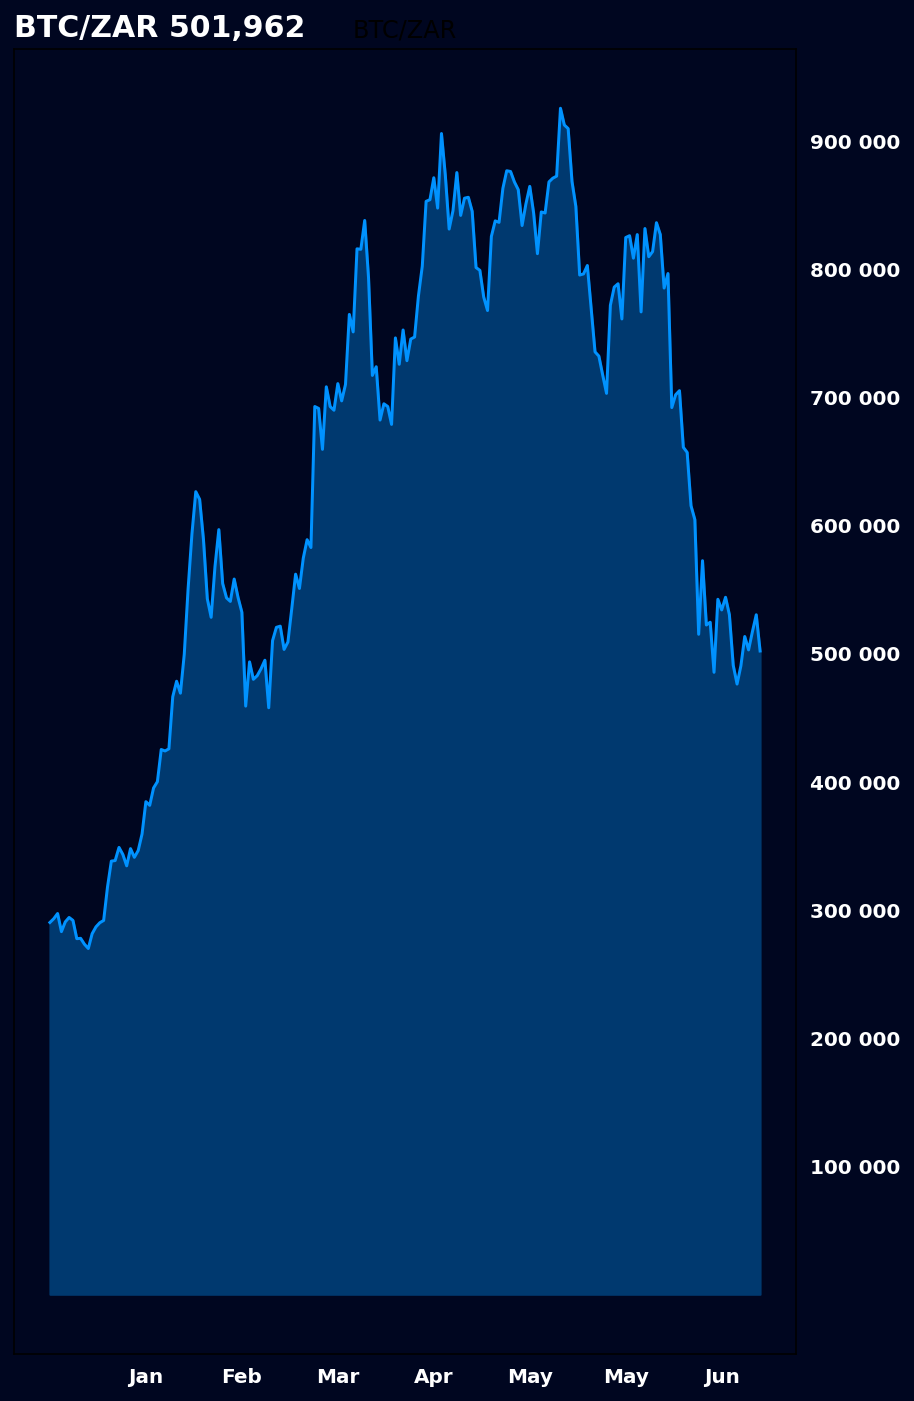

In [3]:
start = "01 December, 2020"
end = "05 June, 2021"

plot_BTC_prices(start, end)